网格信息:
  - 维度: 2
  - 节点数: 1786
  - 单元数: 3172


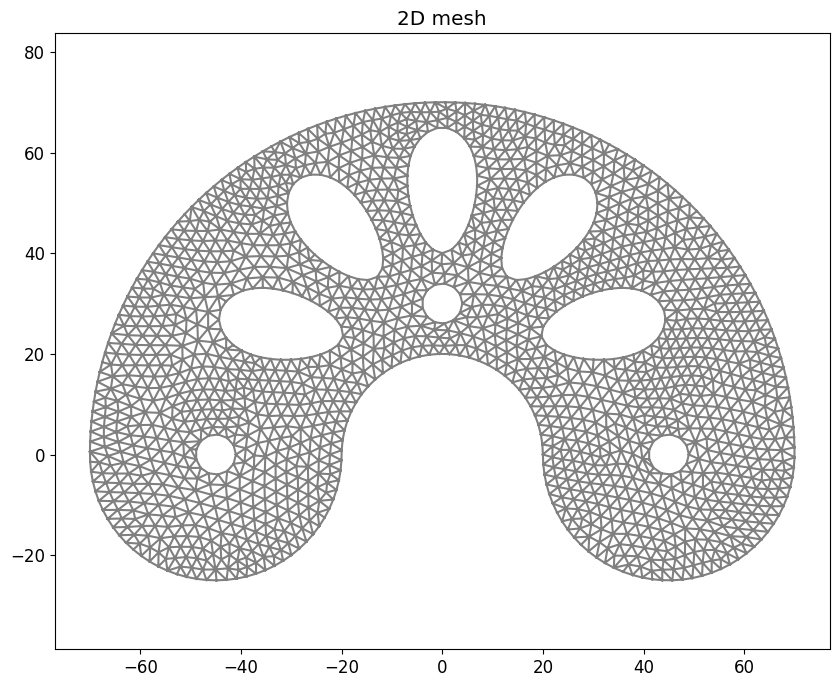

In [124]:
from dolfin import Mesh, XDMFFile, plot
import matplotlib.pyplot as plt

# 步骤1: 使用DOLFIN读取XML文件
xml_input = 'input/topo_shape.xml'
mymesh = Mesh(xml_input)

print(f"网格信息:")
print(f"  - 维度: {mymesh.geometric_dimension()}")
print(f"  - 节点数: {mymesh.num_vertices()}")
print(f"  - 单元数: {mymesh.num_cells()}")

# 步骤2: 显示网格
plt.figure(figsize=(10, 8))
plot(mymesh)
plt.title("2D mesh")
plt.axis('equal')
plt.show()

In [125]:
from fenics import *
# 定义函数空间
V = VectorFunctionSpace(mymesh, "CG", 1)

# 定义边界条件
def left_boundary(x, on_boundary):
    x_min = min(x[0] for x in mymesh.coordinates())
    return on_boundary and x[0] <= x_min + 5

# 左侧固定边界条件
bc = DirichletBC(V, Constant((0, 0)), left_boundary)


# 自然边界
class RightEnd(SubDomain):
    def inside(self, x, on_boundary):
        x_max = max(x[0] for x in mymesh.coordinates())
        return on_boundary and x[0] >= x_max - 5
right_end_boundary = RightEnd()

boundary_mark = MeshFunction("size_t", mymesh, mymesh.topology().dim()-1)
boundary_mark.set_all(0)
right_end_boundary_id = 1
right_end_boundary.mark(boundary_mark, right_end_boundary_id)

# 定义问题
u = TrialFunction(V)
v = TestFunction(V)


In [126]:
#  材料参数 (假设为线性弹性材料)
E = Constant(1e5)  # 杨氏模量
nu = Constant(0.3)  # 泊松比
mu = E / (2 * (1 + nu))
lmbda = E * nu / ((1 + nu) * (1 - 2 * nu))

In [127]:
# 应变和应力
def epsilon(u):
    return 0.5 * (grad(u) + grad(u).T)

def sigma(u):
    return lmbda * tr(epsilon(u)) * Identity(2) + 2 * mu * epsilon(u)

# 变分形式
a = inner(sigma(u), epsilon(v)) * dx

# 右侧施加的力
f = Constant((500.0, 0.0))
L = dot(f, v) * ds(subdomain_data=boundary_mark, domain=mymesh, subdomain_id=right_end_boundary_id)

In [128]:
# 求解问题
u = Function(V)
solve(a == L, u, bc)

# 计算von Mises应力
stress = sigma(u) - (1./3)*tr(sigma(u))*Identity(2)  # 偏应力张量
von_mises = sqrt(3./2*inner(stress, stress))
V_scalar = FunctionSpace(mymesh, "CG", 1)
von_mises_proj = project(von_mises, V_scalar)


Solving linear variational problem.


In [129]:
# 绘制结果
plt.figure(figsize=(12, 5), dpi=1000)

# 变形图
plt.subplot(121)
c1 = plot(u, title='Displacement', mode='displacement')
plt.colorbar(c1, label='Displacement magnitude')

# von Mises应力图
plt.subplot(122)
c2 = plot(von_mises_proj, title='von Mises stress')
plt.colorbar(c2, label='Stress magnitude')

plt.tight_layout()
plt.show()

# 打印最大位移和最大von Mises应力
print(f"Maximum displacement: {u.vector().max():.4f}")
print(f"Maximum von Mises stress: {von_mises_proj.vector().max():.4f}")

Maximum displacement: 5.2183
Maximum von Mises stress: 4622.5607


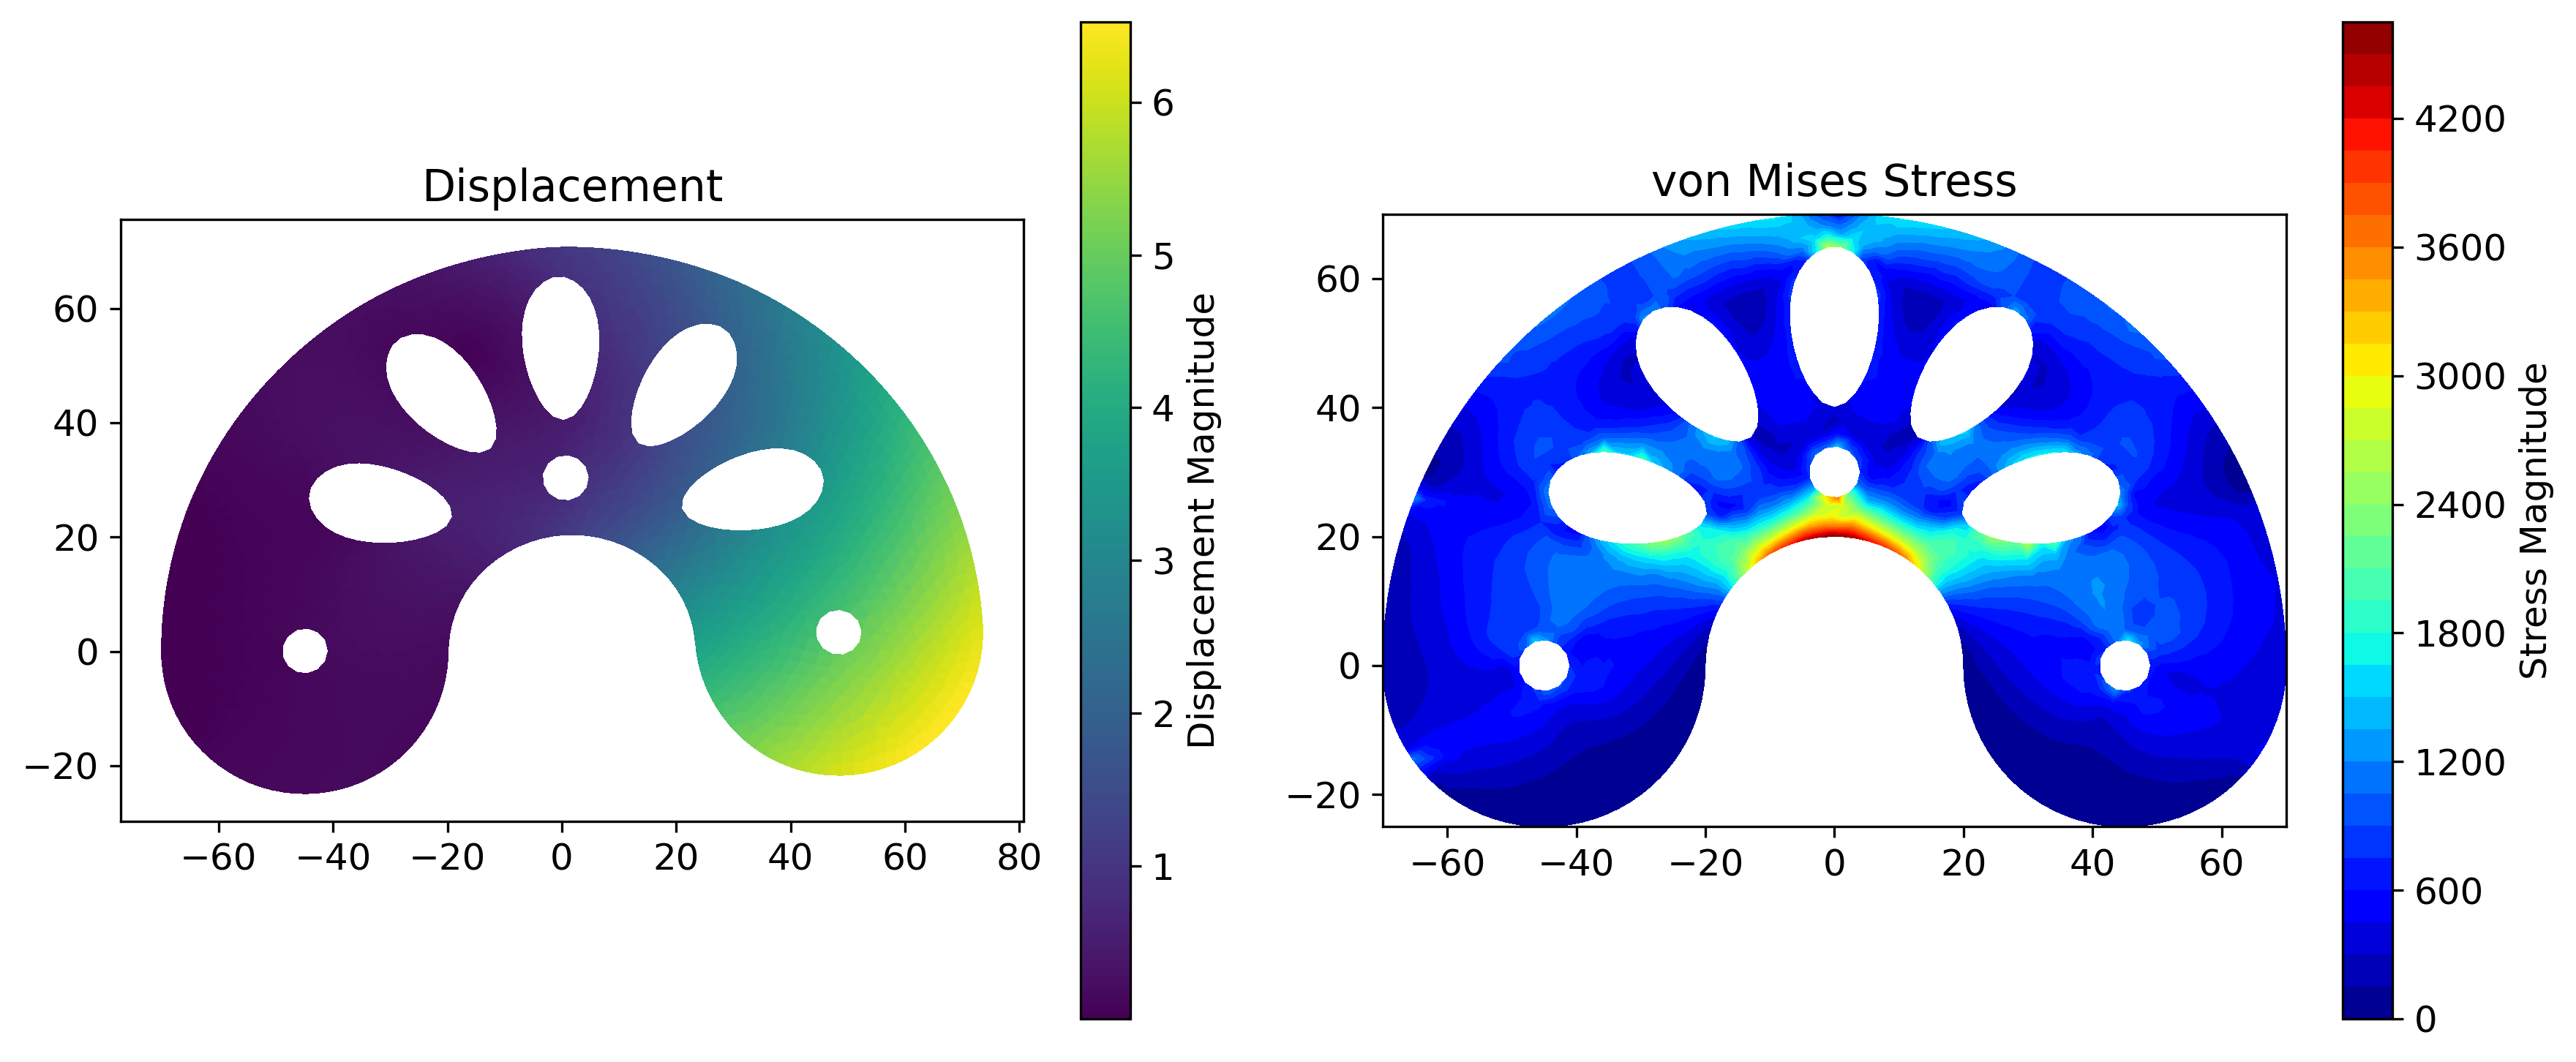

Maximum displacement: 5.2183
Maximum von Mises stress: 4622.5607
Figures displayed


In [130]:
# 设置全局字体大小
plt.rcParams.update({'font.size': 12})

# 绘制结果
plt.figure(figsize=(12, 5), dpi=300)

# 变形图
plt.subplot(121)
c1 = plot(u, title='Displacement', mode='displacement', cmap='viridis')
plt.colorbar(c1, label='Displacement Magnitude')
# plt.grid(True, linestyle='--', alpha=0.7)

# von Mises应力图
plt.subplot(122)
c2 = plot(von_mises_proj, title='von Mises Stress', cmap='jet')
plt.colorbar(c2, label='Stress Magnitude')
# plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 打印最大位移和最大von Mises应力
print(f"Maximum displacement: {u.vector().max():.4f}")
print(f"Maximum von Mises stress: {von_mises_proj.vector().max():.4f}")

print("Figures displayed")

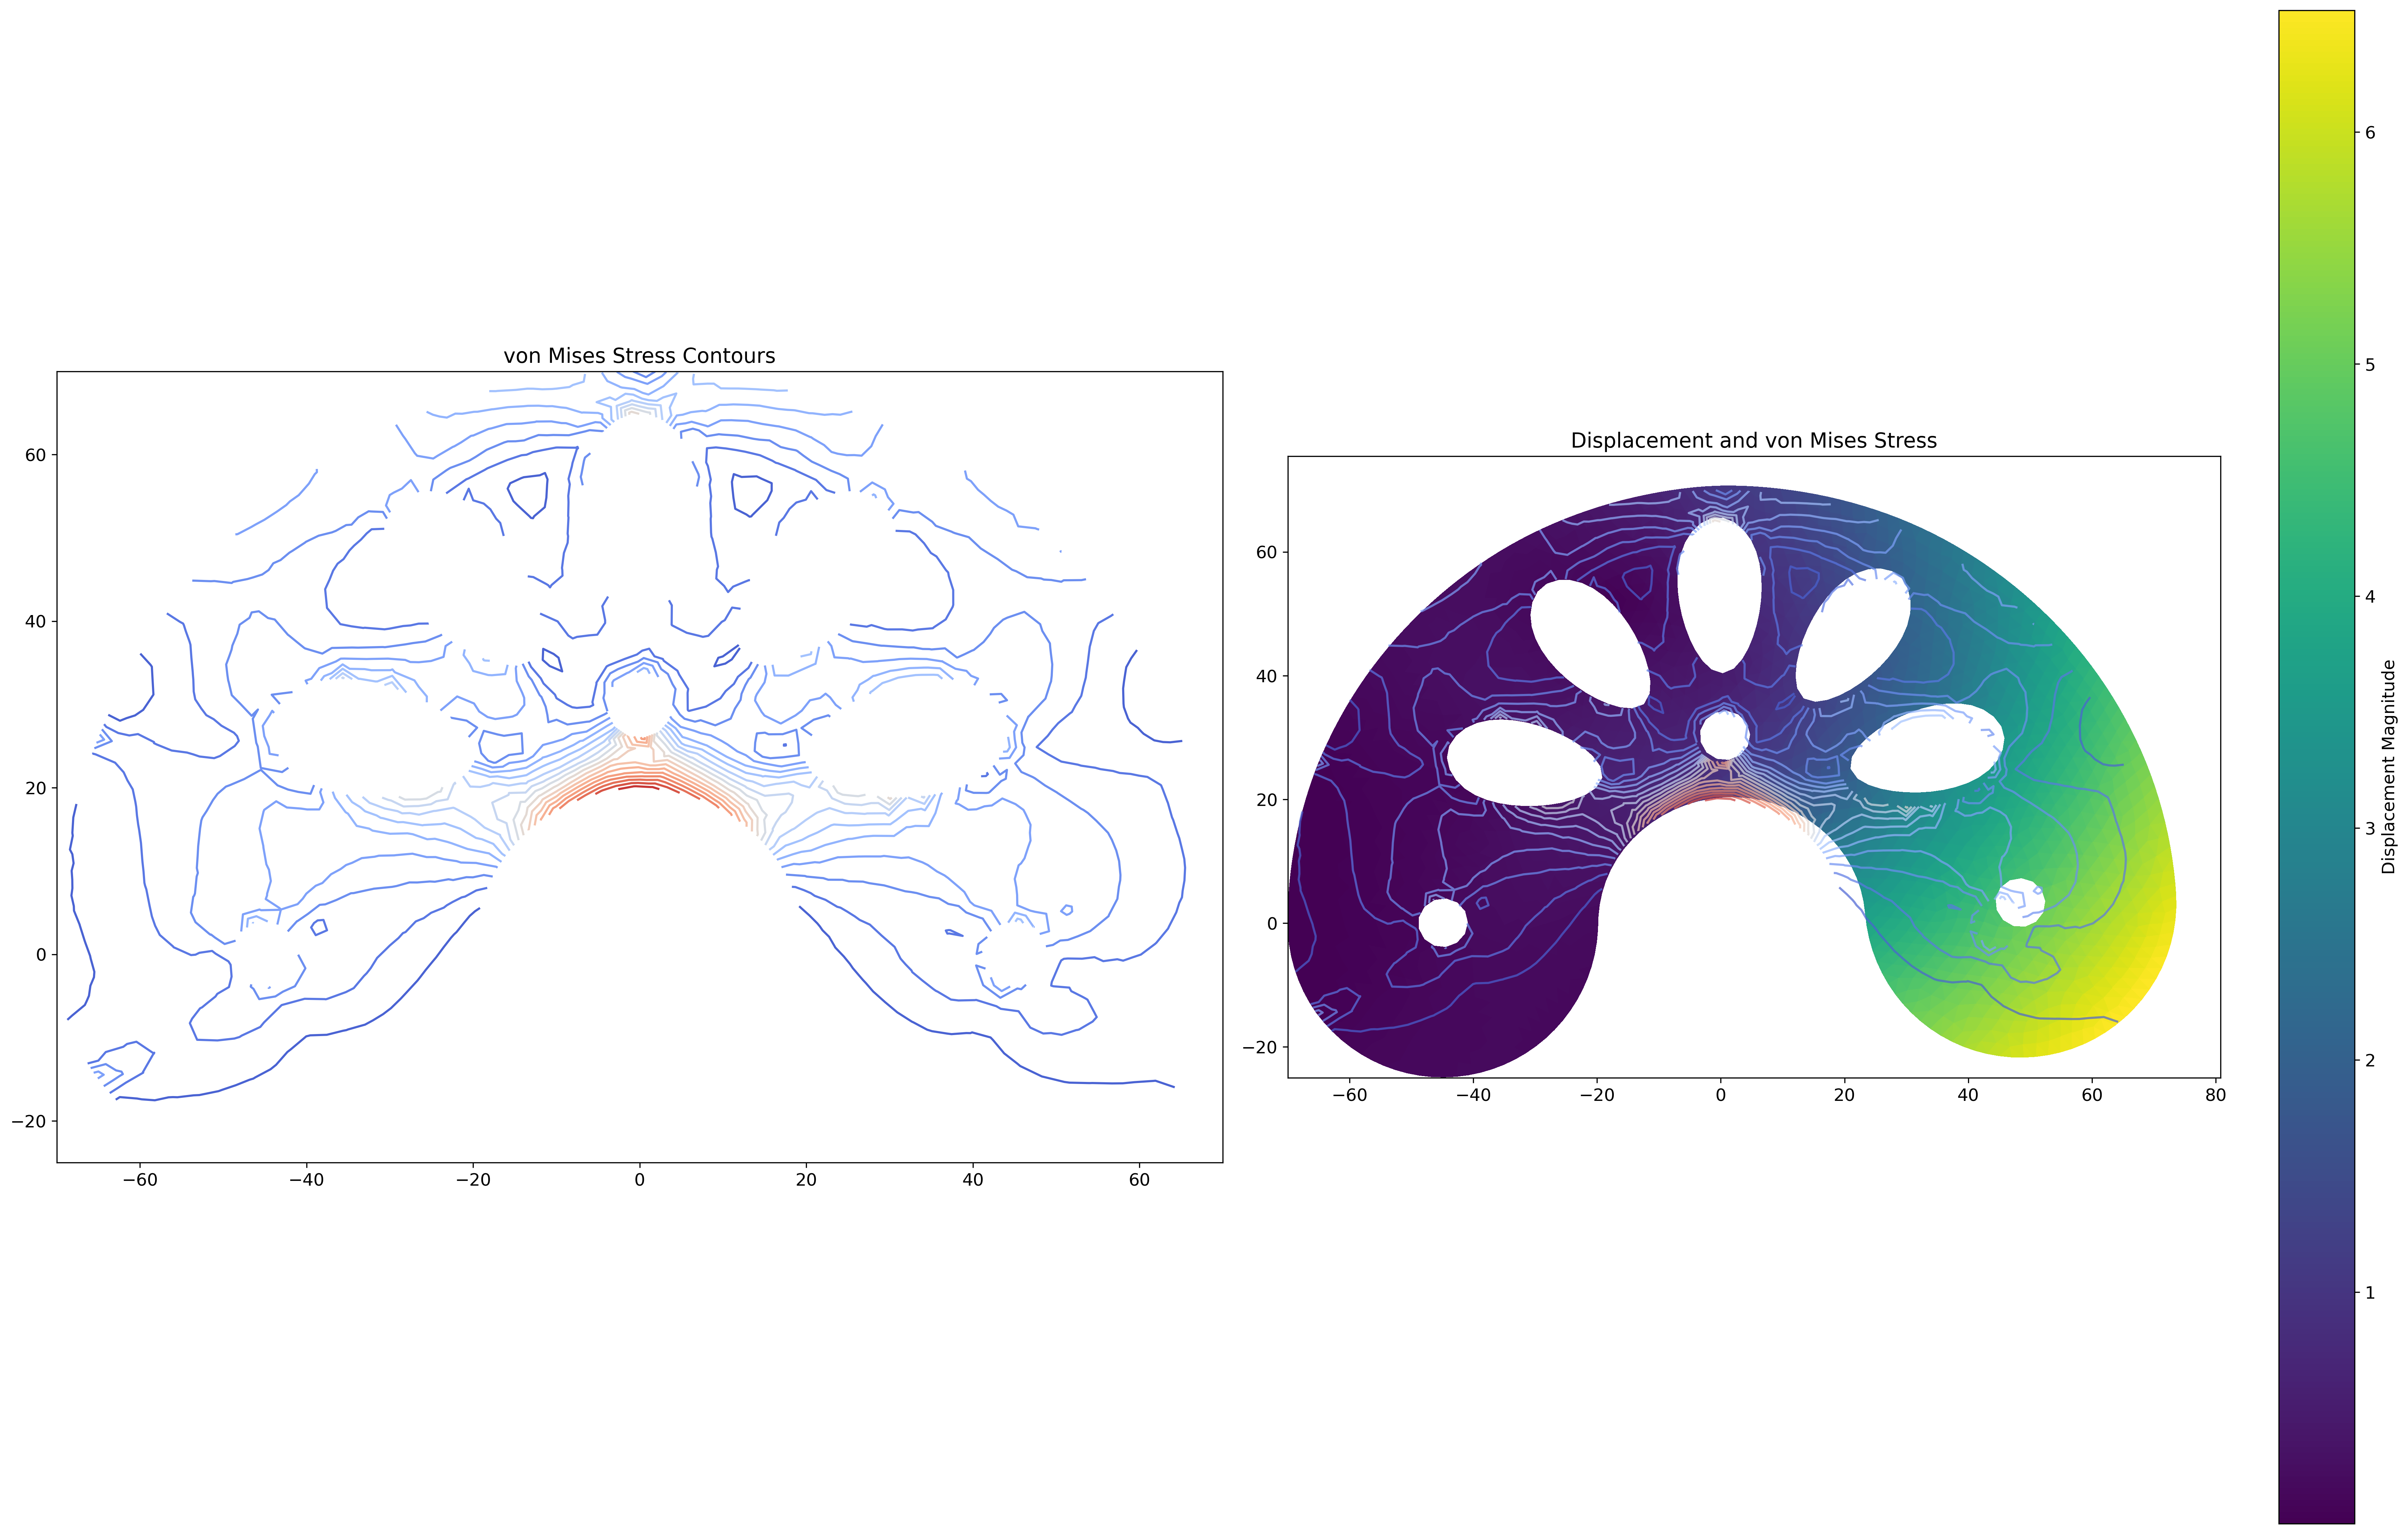

Maximum displacement: 5.2183
Maximum von Mises stress: 4622.5607
Figures displayed
我们创建了两个图表来展示分析结果：
1. von Mises应力等值线图：清晰地显示了应力集中的区域
2. 组合图：同时显示位移和应力，便于观察它们之间的关系
这种展示方法有助于我们更好地理解和分析结构的行为。


In [131]:
# Set global font size
plt.rcParams.update({'font.size': 12})

# Plot results
plt.figure(figsize=(24, 15), dpi=300)

# von Mises stress contour plot
plt.subplot(121)
c3 = plot(von_mises_proj, title='von Mises Stress Contours', mode='contour', levels=20, cmap='coolwarm')

# Combined plot: Displacement and von Mises stress
plt.subplot(122)
c4 = plot(u, title='Displacement and von Mises Stress', mode='displacement', cmap='viridis')
plt.colorbar(c4, label='Displacement Magnitude')
# c5 = plot(von_mises_proj, cmap='coolwarm')
c6 = plot(von_mises_proj, mode='contour', levels=20, cmap='coolwarm', alpha=0.7)


plt.tight_layout()
plt.show()

# Print maximum displacement and maximum von Mises stress
print(f"Maximum displacement: {u.vector().max():.4f}")
print(f"Maximum von Mises stress: {von_mises_proj.vector().max():.4f}")

print("Figures displayed")

# 解释两个图表
print("我们创建了两个图表来展示分析结果：")
print("1. von Mises应力等值线图：清晰地显示了应力集中的区域")
print("2. 组合图：同时显示位移和应力，便于观察它们之间的关系")
print("这种展示方法有助于我们更好地理解和分析结构的行为。")


In [156]:
# 获取每个网格顶点处的应力张量值
import numpy as np
stress_tensor = project(sigma(u), TensorFunctionSpace(mymesh, 'DG', 0))

In [165]:
# 计算每个顶点的最大主应力
principal_stresses = [0] * mymesh.num_vertices()

# 遍历每个顶点，计算s_matrix的特征值和特征向量
for i in range(mymesh.num_vertices()):
    s = stress_tensor(mymesh.coordinates()[i])
    s_matrix = np.array([[s[0], s[1]], [s[2], s[3]]])
    eigvals, eigvecs = np.linalg.eig(s_matrix)
    # print(f"网格顶点编号为{i}的顶点处的特征值: {eigvals}")
    # print(f"网格顶点编号为{i}的顶点处的特征向量: {eigvecs}")
    
# 打印顶点1处的特征值特征向量
s_vertex_1 = stress_tensor(mymesh.coordinates()[1])
s_matrix_vertex_1 = np.array([[s_vertex_1[0], s_vertex_1[1]], [s_vertex_1[2], s_vertex_1[3]]])
eigvals_vertex_1, eigvecs_vertex_1 = np.linalg.eig(s_matrix_vertex_1)
print(f"顶点1处的特征值: {eigvals_vertex_1}")
print(f"顶点1处的特征向量: {eigvecs_vertex_1}")

# 找到最大特征值及其对应的特征向量
max_eigval_index = np.argmax(eigvals_vertex_1)
max_eigval = eigvals_vertex_1[max_eigval_index]
max_eigvec = eigvecs_vertex_1[:, max_eigval_index]
print(f"最大特征值: {max_eigval}")
print(f"对应的特征向量: {max_eigvec}")



# for i in range(mymesh.num_vertices()):
#     s = stress_tensor(mymesh.coordinates()[i])
#     s = np.array(s)  # 将张量转换为np的矩阵
#     if s.ndim < 2:
#         s = np.expand_dims(s, axis=0)
#     if s.shape[-1] != s.shape[-2]:
#         raise np.linalg.LinAlgError("Last 2 dimensions of the array must be square")
#     eigvals = np.linalg.eigvals(s)
#     principal_stresses[i] = max(eigvals)

# # 打印最大主应力
# print(f"Maximum principal stress: {max(principal_stresses):.4f}")

网格顶点编号为0的顶点处的特征值: [ -3.60611861 -14.61452467]
网格顶点编号为0的顶点处的特征向量: [[ 0.78092701  0.62462229]
 [-0.62462229  0.78092701]]
网格顶点编号为1的顶点处的特征值: [-10.93139658 -23.70678412]
网格顶点编号为1的顶点处的特征向量: [[ 0.98795443  0.15474511]
 [-0.15474511  0.98795443]]
网格顶点编号为2的顶点处的特征值: [ -8.25840366 -32.51952037]
网格顶点编号为2的顶点处的特征向量: [[ 0.99943857 -0.0335045 ]
 [ 0.0335045   0.99943857]]
网格顶点编号为3的顶点处的特征值: [ -5.58841336 -39.63873338]
网格顶点编号为3的顶点处的特征向量: [[ 0.99168284 -0.12870562]
 [ 0.12870562  0.99168284]]
网格顶点编号为4的顶点处的特征值: [ -2.50699728 -45.07412822]
网格顶点编号为4的顶点处的特征向量: [[ 0.97814725 -0.20791335]
 [ 0.20791335  0.97814725]]
网格顶点编号为5的顶点处的特征值: [  7.80935323 -48.94755638]
网格顶点编号为5的顶点处的特征向量: [[ 0.94924056 -0.31455106]
 [ 0.31455106  0.94924056]]
网格顶点编号为6的顶点处的特征值: [  4.71966029 -54.49454533]
网格顶点编号为6的顶点处的特征向量: [[ 0.86278693 -0.50556772]
 [ 0.50556772  0.86278693]]
网格顶点编号为7的顶点处的特征值: [ -3.56332421 -64.69413236]
网格顶点编号为7的顶点处的特征向量: [[ 0.83362637 -0.55232878]
 [ 0.55232878  0.83362637]]
网格顶点编号为8的顶点处的特征值: [ -1.32679657 -70.2196